## Цель и описание проекта

Цель данного проекта - создание модели для поиска изображений по текстовым запросам, которая способна оценивать соответствие текста и изображения. При этом необходимо учитывать юридические ограничения: изображения, содержащие детей, должны быть исключены из результатов поиска. Наш целевой признак - вероятность соответствия текста и изображения - будет принимать значения от 0 до 1.

Перед началом исследования мы загрузим и прочитаем весь необходимый набор данных - тренировочную и тестовую выборку и таблицы с краудсорсинговыми и экспертными оценками.

Мы проведем исследовательский анализ тренировочной выборки и выясним, какие слова чаще всего встречаются в текстовых запросах. Анализируя датасеты с краудсорсинговыми и экспертными оценками, мы изобразим на графиках самые часто встречающиеся оценки и долю верных описаний. Мы создадим столбцы с  вероятностью соответствия текста к картинке на основе краудсорсинговых оценок и с агрегированными экспертными оценками, которая будет вычислятся "большинством". Далее мы объединим эти две оценки в одну - используя разные коэффициенты для краудсорсинговых и экспертных оценок - и присоединим финальную оценку к тренировочному датасету по query_id.

Следующим нашим шагом будет создание списка слов, связанных с описанием детей, и функции, которая удалит все текстовые запросы с словами, которые встречаются в этом списке.

Следующим этапом будет векторизация изображений и текстов. Для векторизации изображений мы будем использовать сверточную сеть ResNet50, а для векторизации текста - TF IDF. Далее мы объединим эти вектора в финальный датасет, который будет использоваться для обучения.

Для предсказания нашего целевого признака будут использованы нейронная сеть и регрессионные модели - DummyRegressor, Ridge, RandomForestRegressor. В качестве метрики мы выберем MeanAbsoluteError. Модель с самой низкой метрикой будет использована для предсказания вероятности соответствия текста и изображения на тестовой выборке.

Для предсказания целевого признака на тестовых данных, мы создадим эмбеддинги всех изображений в тестовой выборке, и выберем случайным образом десять текстовых запросов. Далее мы выведем наиболее подходящее изображение для каждого запроса, при этом текстовые запросы, содержащие слова, связанные с описанием детей, обрабатываться не будут - вместо изображения будет показан дисклеймер, информирующий о недоступности изображения в соответствии с законодательными ограничениями.

В конце исследования будет сделан вывод о точности созданной модели. Мы оценим её способность находить релевантные изображения по текстовым запросам.

## Загрузка и исследовательский анализ данных


In [2]:
!pip install -q sentence-transformers

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import string
import seaborn as sns
import os
import random

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_nlp
from keras.callbacks import EarlyStopping
from tqdm import notebook

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from keras.applications.resnet50 import preprocess_input


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
main_path = '/kaggle/input/images'
train_images_dir = '/kaggle/input/train-images'
test_images_dir = '/kaggle/input/test-images-all'
stopwords = stopwords.words('english')
RANDOM_STATE = 42

Загрузим и прочитаем все датасеты.

In [5]:
df_train = pd.read_csv(Path(main_path, 'train_dataset.csv'))
df_crowd = pd.read_csv(Path(main_path, 'CrowdAnnotations.tsv'), sep='\t',
                       names=['image', 'query_id', 'share_pos', 'num_pos', 'num_neg'])
df_expert = pd.read_csv(Path(main_path, 'ExpertAnnotations.tsv'), sep='\t',
                        names=['image', 'query_id', 'first_expert',
                               'second_expert', 'third_expert'])
df_test = pd.read_csv(Path(main_path, 'test_queries.csv'), index_col=[0], sep='|')
df_test_images = pd.read_csv(Path(main_path, 'test_images.csv'), sep='|')

In [6]:
df_train.head(10)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...  
8  A young child is wearing blue goggles and sitt...  
9  A young child is wearing blue goggles and sitt...

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [8]:
print(f"Кол-во уникальных картинок в тренировочном датасете {df_train['image'].nunique()}")
print(f"Кол-во уникальных описаний в тренировочном датасете {df_train['query_id'].nunique()}")

Кол-во уникальных картинок в тренировочном датасете 1000
Кол-во уникальных описаний в тренировочном датасете 977


Тренировочные данные содержат 5822 строк с 1000 уникальными изображениями и 977 уникальными описаниями. Каждая картинка может иметь до пяти описаний.

Следующим нашим шагом будет создание графика с самыми популярными словами в описаниях, исключая стоп слова.

In [9]:
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    words = [word for word in text.split() if word not in stopwords]
    return words

In [10]:
all_words = []
df_train['query_text'].apply(lambda x: all_words.extend(clean_text(x)))
word_counts = Counter(all_words)

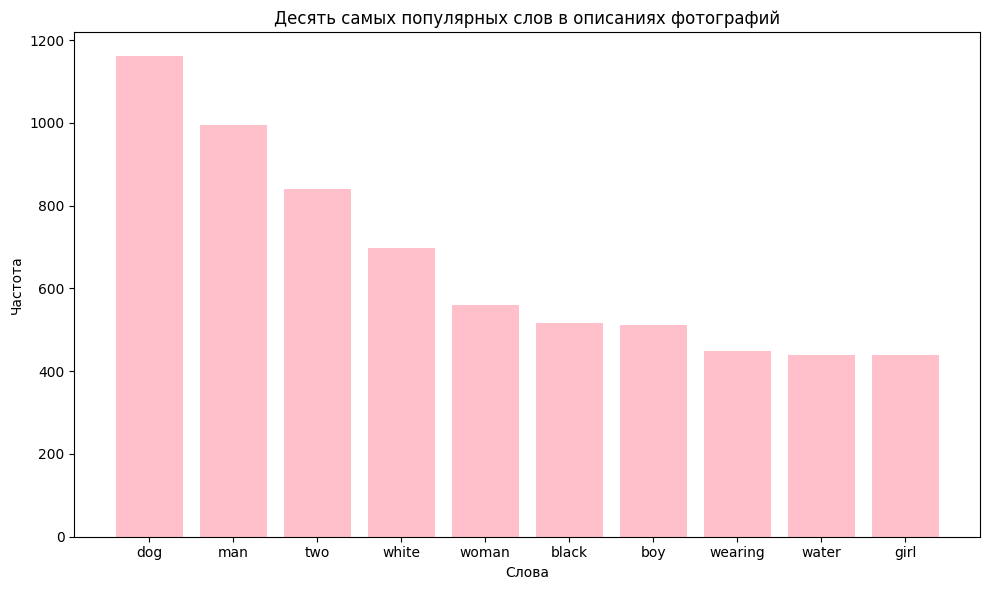

In [11]:
most_common_words = word_counts.most_common(10)

words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='pink')
plt.title('Десять самых популярных слов в описаниях фотографий')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

В нашей тренировочной выборке представлено больше всего фотографий с собаками и мужчинами. Около 1000 фотографий содержат в описании детей - эти фотографии необходимо будет исключить из обучения модели.

In [12]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   num_pos    47830 non-null  int64  
 4   num_neg    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [13]:
df_crowd.head(10)

image                     query_id  share_pos  num_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000        0   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000        0   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000        0   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333        1   
8  1056338697_4f7d7ce270.jpg  2307118114_c258e3a47e.jpg#2   0.000000        0   
9  1056338697_4f7d7ce270.jpg  2309860995_c2e2a0feeb.jpg#2   0.000000        0   

   num_neg  
0        0  
1        3  
2        3  
3        3  
4        3  
5        3  
6        3  
7        2  
8        3  
9        3

В данных с краудсорсинговыми оценками мы видим 47 830 строк без пропусков.

Создадим график с изображением доли верных и неверных описаний в датасете с краудсорсинговыми оценками.

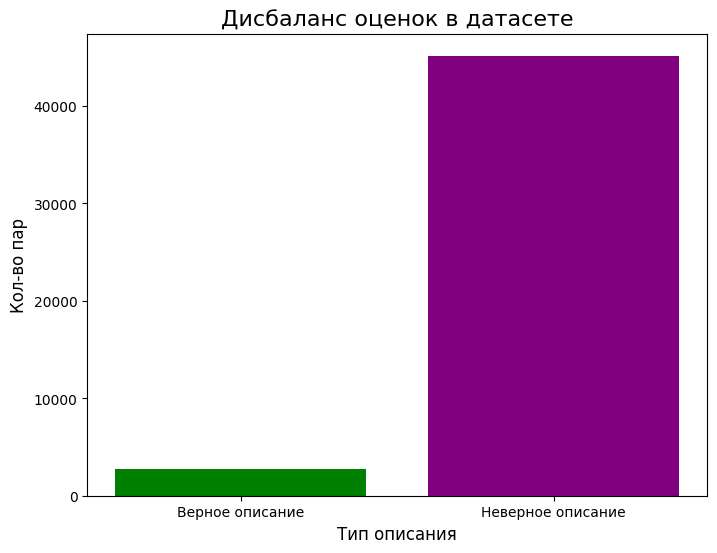

In [14]:
total_correct_pairs = (df_crowd['num_pos'] > df_crowd['num_neg']).sum()
total_incorrect_pairs = (df_crowd['num_pos'] <= df_crowd['num_neg']).sum()

data_pairs = {'Верное описание': total_correct_pairs, 'Неверное описание': total_incorrect_pairs}

plt.figure(figsize=(8, 6))
plt.bar(data_pairs.keys(), data_pairs.values(), color=["green", "purple"])
plt.xlabel('Тип описания', fontsize=12)
plt.ylabel('Кол-во пар', fontsize=12)
plt.title('Дисбаланс оценок в датасете', fontsize=16)

plt.show()

Данный график показывает реальное количество пар изображение/описание. Мы видим, что в датасете с краудсорсинговыми оценками сильный дисбаланс классов верного / неверного описания, в данных намного больше пар с неверным описанием.

Было принято решение создать столбец с вероятностью соответствия текста к картинке на основе краудсорсинговых оценок с помощью функции. Мы также удалим строки с недостаточным количеством голосов.

In [15]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   num_pos    47830 non-null  int64  
 4   num_neg    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [16]:
df_crowd.head(5)

image                     query_id  share_pos  num_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0        3   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0        0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0        0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0        0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0        0   

   num_neg  
0        0  
1        3  
2        3  
3        3  
4        3

In [17]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [18]:
df_expert.head(10)

image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2             1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2             1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2             1   
8   106490881_5a2dd9b7bd.jpg  1425069308_488e5fcf9d.jpg#2             1   
9   106490881_5a2dd9b7bd.jpg  1714316707_8bbaa2a2ba.jpg#2             2   

   second_expert  third_expert  
0              1             1  
1              1             2  
2              1             2  
3              2             2  
4              1             2  
5              1             1  
6              1             1  
7              1             2  
8              1             1  
9              2             2

В датасете с экспертными оценками представлены 5822 оценки от трех разных экспертов. Пропуски отсутствуют.

In [19]:
df_expert['average_score'] = df_expert[['first_expert',
                                        'second_expert', 'third_expert']].mean(axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


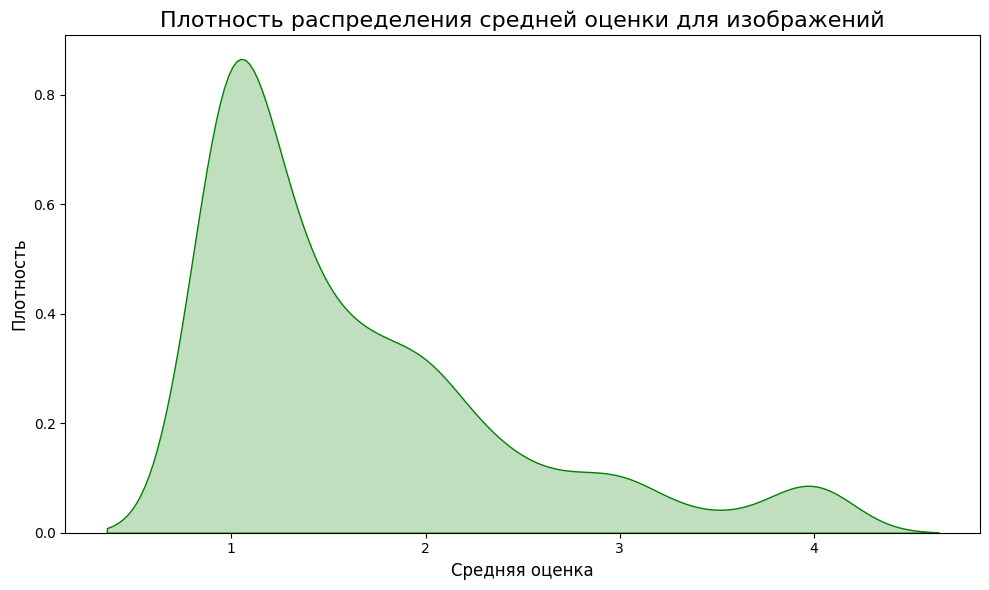

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_expert['average_score'], fill=True, color='green', bw_adjust=1.5)
plt.title("Плотность распределения средней оценки для изображений", fontsize=16)
plt.xlabel("Средняя оценка", fontsize=12)
plt.ylabel("Плотность", fontsize=12)
plt.tight_layout()
plt.show();

Построив график с средними оценками соответствия изображения и запроса. Мы видим,что подавляющее большинство пар изображения-запрос не соответствуют друг другу, либо запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует. В датасете представлено совсем немного пар, где запрос и текст соответствуют полностью.

С помощью функции создадим столбец с агрегированными оценками, которая вычисляется "большинством" - если хотя бы одна оценка встречается минимум дважды, считается, что у этой строки есть "большинство". Далее мы нормализуем данную оценку, чтобы она была в диапазоне от 0 до 1.

Если явного большинства нет, то возвращается None. Такие строки удаляются.

In [21]:
def aggregate_scores(row):
    scores = [row['first_expert'], row['second_expert'], row['third_expert']]
    score_counts = pd.Series(scores).value_counts()
    if score_counts.max() >= 2:
        majority_score = score_counts.idxmax()
        return (majority_score - 1) / 3 #нормализация
    else:
        return None
df_expert['aggregated_score'] = df_expert.apply(aggregate_scores, axis=1)

#удаляем строки с none в столбце с агрегированной оценкой
df_expert = df_expert.dropna(subset=['aggregated_score'])

In [22]:
df_expert.head(5)

image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2             1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2             1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2             1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2             1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2             1   

   second_expert  third_expert  average_score  aggregated_score  
0              1             1       1.000000          0.000000  
1              1             2       1.333333          0.000000  
2              1             2       1.333333          0.000000  
3              2             2       1.666667          0.333333  
4              1             2       1.333333          0.000000

In [23]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5696 non-null   object 
 1   query_id          5696 non-null   object 
 2   first_expert      5696 non-null   int64  
 3   second_expert     5696 non-null   int64  
 4   third_expert      5696 non-null   int64  
 5   average_score     5696 non-null   float64
 6   aggregated_score  5696 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 356.0+ KB


Мы создали столбец с агрегированной оценкой, исходя из самой популярной оценки среди трех экспертов. Строки, где у каждого эксперта были разные оценки (примерно 200), были удалены. 

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [25]:
df_test.head(10)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   
8  1232148178_4f45cc3284.jpg#3   
9  1232148178_4f45cc3284.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   
8  A young girl is smiling in front of the camera...   
9  There is a little blond hair girl with a green...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg  
8  1232148178_4f45cc3284.jpg  
9  1232148178_4f45cc3284.jpg

In [26]:
df_test_images.head(5)

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [27]:
df_test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


Тестовая выборка содержит 100 изображений и 500 описаний.

In [28]:
#создадим единую таблицу с краудсорсинговыми и экспертными оценками
merged_data = pd.merge(
    df_expert, df_crowd, 
    on=['image', 'query_id'], 
    how='outer'
)

In [29]:
#напишем функцию, которая объединит экспертную и краудсортинговую оценки в одну
def unite_score(row):
    expert_score = row['aggregated_score']
    crowd_score = row['share_pos']
    if pd.isna(expert_score): 
        return crowd_score
    elif pd.isna(crowd_score):
        return expert_score
    return (0.6 * expert_score) + (0.4 * crowd_score)

merged_data['final_score'] = merged_data.apply(unite_score, axis=1)

In [30]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51268 entries, 0 to 51267
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             51268 non-null  object 
 1   query_id          51268 non-null  object 
 2   first_expert      5696 non-null   float64
 3   second_expert     5696 non-null   float64
 4   third_expert      5696 non-null   float64
 5   average_score     5696 non-null   float64
 6   aggregated_score  5696 non-null   float64
 7   share_pos         47830 non-null  float64
 8   num_pos           47830 non-null  float64
 9   num_neg           47830 non-null  float64
 10  final_score       51268 non-null  float64
dtypes: float64(9), object(2)
memory usage: 4.3+ MB


In [31]:
merged_data.head(5)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


image                     query_id  first_expert  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           NaN   

   second_expert  third_expert  average_score  aggregated_score  share_pos  \
0            NaN           NaN            NaN               NaN        1.0   
1            NaN           NaN            NaN               NaN        0.0   
2            NaN           NaN            NaN               NaN        0.0   
3            NaN           NaN            NaN               NaN        0.0   
4            NaN           NaN            NaN               NaN        0.0   

   num_pos  num_neg  final_score  
0      3.0      0.0          1.0  
1      0.0      3.0          0.0  
2      0.0      3.0          0.0  
3      0.0      3.0          0.0  
4      0.0      3.0          0.0

Объеденим тренировочную выборку и датасет с финальной оценкой.

In [32]:
df_train = pd.merge(df_train, merged_data[['image', 'query_id', 'final_score']],
                    how='outer', on=['image', 'query_id'])
unique_texts = df_train[['query_id', 'query_text']].dropna().drop_duplicates()
#переменная с уникальными описаниями

In [34]:
#добавляем запросы обратно в df_train как уникальные значения на основе query_id

df_train = df_train.drop(columns=['query_text'], errors='ignore')
df_train = df_train.merge(unique_texts, on='query_id', how='left')

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   query_id     51323 non-null  object 
 2   final_score  51268 non-null  float64
 3   query_text   50214 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [36]:
df_train.head(5)

image                     query_id  final_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1          A boy in glasses is wearing a red shirt .  
2   A young boy holds onto a blue handle on a pier .  
3  A woman wearing black clothes , a purple scarf...  
4  An older woman with blond hair rides a bicycle...

In [37]:
print(f'Количество дубликатов - {df_train.duplicated().sum()}')

Количество дубликатов - 0


In [38]:
df_train.isna().sum()

image             0
query_id          0
final_score      55
query_text     1109
dtype: int64

In [39]:
#удаляем пропуски
df_train.dropna(subset=['final_score','query_text'],inplace=True)

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50159 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50159 non-null  object 
 1   query_id     50159 non-null  object 
 2   final_score  50159 non-null  float64
 3   query_text   50159 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


Наша тренировочная выборка готова к обучению. Мы рассчитали целевую переменную (вероятность соответствия запроса к картинке) к каждой строке, объединили с тренировочными данными, убрали пропуски и проверили датасет на наличие дубликатов.

Создадим функцию для показа первых пяти фотографий из тренировочного и тестового датасета.

In [41]:
def show_pic(df, path):
    sample = df.head(5)
    fig, axes = plt.subplots(1, len(sample), figsize=(15, 5))
    for idx, (i, row) in enumerate(sample.iterrows()):
        image_path = os.path.join(path, row['image'])
        img = Image.open(image_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

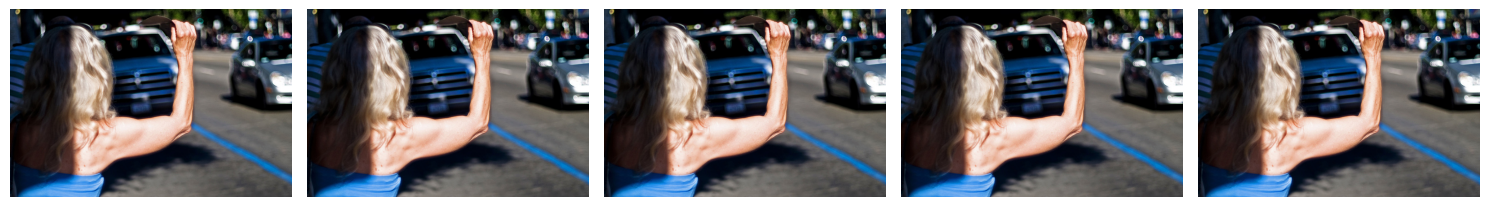

In [42]:
show_pic(df_train, train_images_dir)

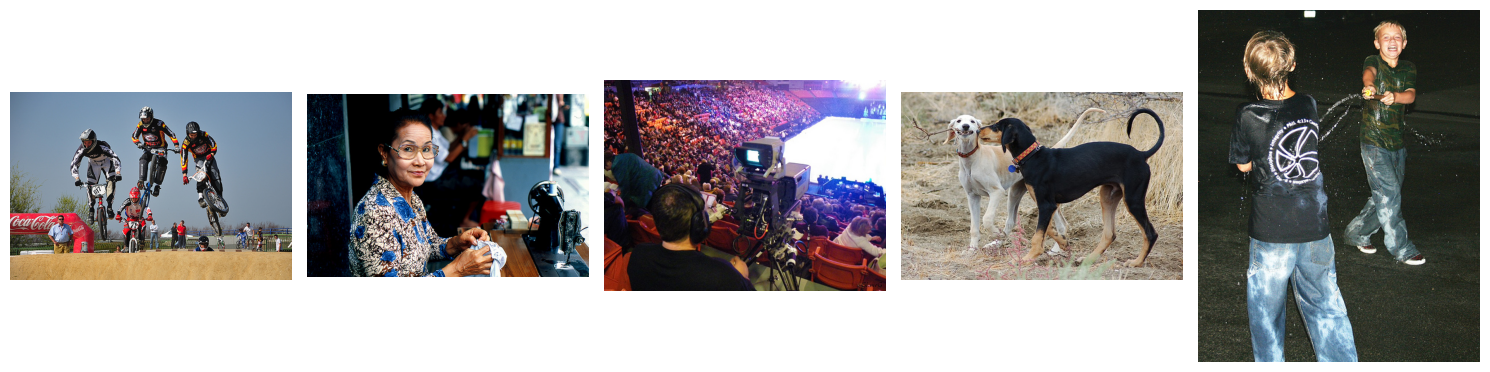

In [43]:
show_pic(df_test_images, test_images_dir)

При просмотре изображений из тренировочной и тестовой выборки, можно заметить фотографии детей, которые будет необходимо удалить из выборки. Этим мы займемся в следующем шаге.

Мы загрузили и просмотрели все датасеты, провели исследовательский анализ тренировочной выборки - нашли самые используемые слова в описаниях, проанализировали, что самая частая краудсорсинговая оценка показывает, что картинка и запрос не соответствуют друг другу, в экспертных оценках также несоответствие встречается чаще.

Мы создали функцию, которые посчитали вероятность соответствия запроса и картинки на основе краудсорсинговых оценок, и функцию, которая агрегирует экспертные оценки на основе большинства. Далее мы объединили данные оценки в одну финальную - используя разные коэффициенты для краудсорсинговой и экспертной оценки.

Следующим нашим шагом было объединение тренировочной выборки и финальных оценок.

Проанализировав краудсорсинговые и экспертные оценки, в большинстве случаев было замечено несоответствие описания и изображения. Этот факт, скорее всего, негативно скажется на модели, которая не сможет достаточно хорошо прогнозировать соответствие запроса и изображения.

##  Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.
В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

⎪ This image is unavailable in your country in compliance with local laws

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Создадим список слов, которые указывают на содержание детей на изображении.

In [44]:
underage_keywords = [
    "boy","girl", "girls","kids", "boys","child", "children", "kid", "kids", "minor", "teenager", "teen", "adolescent", "juvenile",
    "preteen", "underage", "infant", "toddler", "baby", "preschooler", "schoolchild", "young",
    "youth", "kid's", "child's", "under 18", "nursery", "daycare", "playground", "youngster",
    "pre-adolescent", "little", "prepubescent", "youthfulness", "early age"
]

Cоздадим функцию,которая отфильтрует наш датасет, удалив описания, в которых встречаются слова из underage_keywords.


In [45]:
def contains_keywords(description):
    for word in underage_keywords:
        if word.lower() in description.lower():
            return True
    return False


In [46]:
df_train['underage'] = df_train['query_text'].apply(contains_keywords)
query_ids_underage = df_train[df_train['underage'] == True]['query_id'].unique()
trimmed_query_ids = [query_id[:-2] for query_id in query_ids_underage]
df_train = df_train[~df_train['image'].isin(trimmed_query_ids)]

In [47]:
df_train.drop(columns='underage',axis=1,inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34893 entries, 0 to 34892
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        34893 non-null  object 
 1   query_id     34893 non-null  object 
 2   final_score  34893 non-null  float64
 3   query_text   34893 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [49]:
df_train.head(5)

image                     query_id  final_score  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1          A boy in glasses is wearing a red shirt .  
2   A young boy holds onto a blue handle on a pier .  
3  A woman wearing black clothes , a purple scarf...  
4  An older woman with blond hair rides a bicycle...

## Векторизация изображений

Перейдём к векторизации изображений.
Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют «выделить» главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [50]:
def load_train(path):
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=path,
        x_col='image',
        y_col='final_score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        shuffle = False,
        seed=12345)

    return train_gen_flow

In [51]:
train_gen_flow = load_train(train_images_dir)

Found 34893 validated image filenames.


In [52]:
def create_model(input_shape = (224,224,3)):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

In [53]:
def vect_predict(model, df):
    predictions = model.predict(df)
    return predictions

In [54]:
image_embeds = vect_predict(create_model(), train_gen_flow)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2181/2181 ━━━━━━━━━━━━━━━━━━━━ 171s 76ms/step


In [55]:
image_embeds.shape

(34893, 2048)

Мы получили эмбеддинги наших изображений.

## Векторизация текстов

In [56]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

Mounting files to /kaggle/input/bert/keras/bert_base_en/2...


In [57]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

In [58]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0):

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

In [59]:
text = list(df_train['query_text'])
text_embeds = vectorize_text(model=bert, data=text)


  0%|          | 0/1091 [00:00<?, ?it/s]

In [60]:
text_embeds.shape

(34893, 768)

Мы получили векторные представления для текстов.

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [61]:
#объединяем векторы изображений и текстов
combined_features = np.hstack([image_embeds, text_embeds])
target = np.array(df_train['final_score'])

In [62]:
print(combined_features.shape)
print(target.shape)

(34893, 2816)
(34893,)


Наша финальная тренировочная выборка состоит из 34 893 строк и 2816 признаков.

## Обучение модели предсказания соответствия


Наш целевой признак - вероятность соответствия изображения тексту, которая принимает непрерывные значения от 0 до 1. Поэтому, мы будем решать задачу регресии.

Для оценки качества моделей была выбрана метрика MeanAbsoluteError, так как она ее легко интерпретировать и ее проще использовать для обучения.

Сначала мы обучим модель на DummyRegressor, чтобы посчитать метрику модели, которая предсказывает константу. Все дальнейшие метрики мы сравним с MAE у DummyRegressor, чтобы быть уверенными, что остальные модели действительно находят связи между входными и целевым признаками.

Нашими основными моделями будут Ridge, RandomForestRegressor и нейронная сеть.

In [63]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, val_indices = next(gss.split(X=combined_features,
                                             y=target,
                                             groups=df_train['image']))


In [64]:
X_train, X_val = combined_features[train_indices], combined_features[val_indices]
y_train, y_val = target[train_indices], target[val_indices]

In [65]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(24843, 2816) (24843,)
(10050, 2816) (10050,)


### Dummy, Ridge, RandomForest

Все наши признаки - количественные, поэтому перед обучением необходимо стандартизировать все входные признаки в тренировочной и тестовой выборке.

In [66]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [67]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_val)
dummy_mae = mean_absolute_error(y_val,dummy_preds)
print('MAE на Dummy модели', dummy_mae)

MAE на Dummy модели 0.14141037537960613


In [68]:
ridge_model = Ridge(random_state = RANDOM_STATE, alpha  = 2)

In [69]:
ridge_model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.47721e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=2, random_state=42)

In [70]:
ridge_preds= ridge_model.predict(X_val)
ridge_mae = mean_absolute_error(y_val,ridge_preds)
print(f'MAE Ridge {ridge_mae}')

MAE Ridge 0.13281337227359735


In [71]:
forest_model = RandomForestRegressor(random_state=RANDOM_STATE, max_depth = 17,n_estimators=5)

In [72]:
forest_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=17, n_estimators=5, random_state=42)

In [73]:
forest_preds = forest_model.predict(X_val)
forest_mae = mean_absolute_error(y_val,forest_preds)
print(f'MAE RandomForestRegressor {forest_mae}')

MAE RandomForestRegressor 0.12926441462763127


MAE у DummyRegressor - модели, которая предсказывает константу, равен 0.14. Это значит, мы будем ориентироваться только на те модели, которые показывают метрику еще ниже.
В нашем случае MAE у Ridge и RandomForest равен 0.13 и 0.12 соответсвенно. Следующим шагом будет создание нейронной сети.

### Нейронная сеть

Нейронная сеть для решения нашей задачи представляет собой полносвязную сеть с тремя   слоями. Функция активации входного и скрытого слоя - ReLu, выходного - Sigmoid. Мы дважды используем Dropout для предотвращения переобучения.

В качестве оптимизатора мы выбрали Adam c установленной скоростью обучения 0.001.

В качестве функции потерь была выбрана MSE.

In [74]:
from tensorflow.keras import regularizers

In [75]:
nn_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  
    ])

optimizer = Adam(learning_rate=0.0001)


nn_model.compile(optimizer=optimizer, loss=['mean_squared_error'],
            metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32, epochs=50,
    verbose=2, shuffle=False
    )

Epoch 1/50
777/777 - 7s - 9ms/step - loss: 0.0638 - mae: 0.1278 - val_loss: 0.0524 - val_mae: 0.0952
Epoch 2/50
777/777 - 2s - 2ms/step - loss: 0.0499 - mae: 0.1067 - val_loss: 0.0494 - val_mae: 0.0994
Epoch 3/50
777/777 - 2s - 2ms/step - loss: 0.0473 - mae: 0.1075 - val_loss: 0.0475 - val_mae: 0.1012
Epoch 4/50
777/777 - 2s - 2ms/step - loss: 0.0462 - mae: 0.1068 - val_loss: 0.0479 - val_mae: 0.1012
Epoch 5/50
777/777 - 2s - 2ms/step - loss: 0.0450 - mae: 0.1050 - val_loss: 0.0483 - val_mae: 0.1001
Epoch 6/50
777/777 - 2s - 2ms/step - loss: 0.0436 - mae: 0.1050 - val_loss: 0.0464 - val_mae: 0.1047
Epoch 7/50
777/777 - 2s - 2ms/step - loss: 0.0430 - mae: 0.1036 - val_loss: 0.0465 - val_mae: 0.1023
Epoch 8/50
777/777 - 2s - 2ms/step - loss: 0.0423 - mae: 0.1028 - val_loss: 0.0454 - val_mae: 0.1050
Epoch 9/50
777/777 - 2s - 2ms/step - loss: 0.0416 - mae: 0.1022 - val_loss: 0.0459 - val_mae: 0.1045
Epoch 10/50
777/777 - 2s - 2ms/step - loss: 0.0407 - mae: 0.1005 - val_loss: 0.0452 - val_m

In [77]:
nn_preds = nn_model.predict(X_val)
nn_mae = mean_absolute_error(nn_preds, y_val)

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [78]:
print(f"MAE у нейронной сети {nn_mae}")

MAE у нейронной сети 0.08977482586775622


In [79]:
model_names = ['Dummy','Ridge','RandomForest','Neural Network']
mae_values = [dummy_mae, ridge_mae, forest_mae, nn_mae]
mae_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_values
})
mae_df.sort_values(by = 'MAE')

Model       MAE
3  Neural Network  0.089775
2    RandomForest  0.129264
1           Ridge  0.132813
0           Dummy  0.141410

Таблица с лучшей MSE метрикой каждой модели показывает, что нейронная сеть предсказывает целевой признак точнее всего. Именно эта модель будет использоваться для тестовой выборки.

На протяжении 20 эпох нейронная сеть показывала приблизительно один и тот же результат - метрика и лосс не менялись радикально.

## Тестирование модели


In [80]:
def load_test(path):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_test_images,
        directory=path,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        shuffle = False,
        seed=12345)

    return test_gen_flow

In [81]:
test_gen_flow = load_test(test_images_dir)
test_image_embeds = vect_predict(create_model(),test_gen_flow)

Found 100 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step


In [82]:
test_image_embeds.shape

(100, 2048)

Создадим функцию, которая выведет наиболее релевантное изображение для десяти случайных запросов. При запросе, описывающем детей, будет показано предупреждение

In [83]:
def contains_underage_keywords(query, underage_keywords):
    for keyword in underage_keywords:
        if keyword.lower() in query.lower():
            return True
    return False

In [84]:
def get_picture(text) -> None:
        if contains_underage_keywords(text, underage_keywords):
            print(text)
            print("Warning:  This image is unavailable in your country in compliance with local laws")
        else:
            text_embed = vectorize_text(data=[text],model=bert,bar=False)
            X = np.concatenate(( 
                test_image_embeds,
                np.resize(text_embed, (test_image_embeds.shape[0],768))),
                axis=1)
            X = scaler.transform(X)
            predictions = nn_model.predict(X)
            df = pd.concat((df_test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
            top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
            top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
            print(text)
            fig = plt.figure(figsize=(15,5))
            plt.rcParams['axes.edgecolor'] = 'black'
            plt.rcParams['axes.linewidth'] = 0
            for i, (img, score) in enumerate(zip(top, top_score)):
                ax = fig.add_subplot(1, 6, i + 1)
                ax.imshow(Image.open(Path(test_images_dir, img)))
                ax.set_title(round(score, 2))
                ax.axis('off')
        
            if text in list(df_test['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
                plt.rcParams['axes.edgecolor'] = 'green'
                plt.rcParams['axes.linewidth'] = 5
                fig.add_subplot(1, 6, 6)
                image = Image.open(Path(test_images_dir, df_test.iloc[df_test[df_test['query_text'] == text].index[0]]['image']))
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
                plt.tight_layout()
        
            plt.show()

In [85]:
samples = df_test.sample(10)
list_samples = list(samples['query_text'])

A young boy poses for a picture in front of a playground .
A woman is throwing a bucket of water over a baby in the paddling pool .
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
A red high speed racing boat skips across the water .


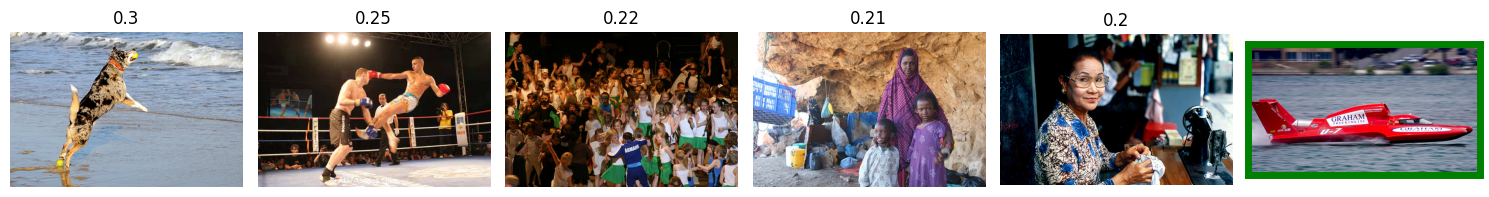

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
A biker is racing to keep up with the runners


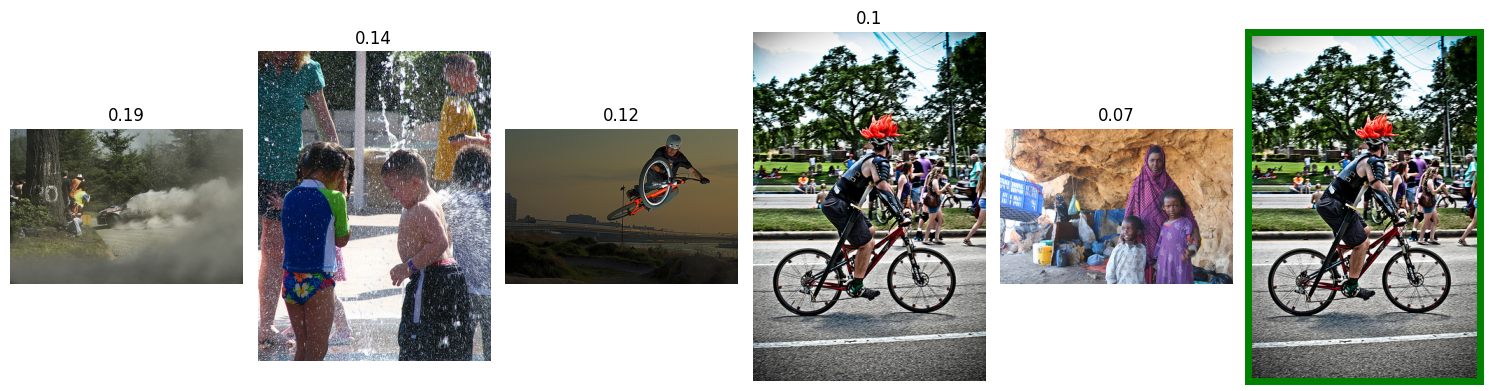

a group of teenagers standing outside of a convienance store .
Little kid in blue coat and hat riding a tricycle .
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
A group of people in anime cosplay costumes .


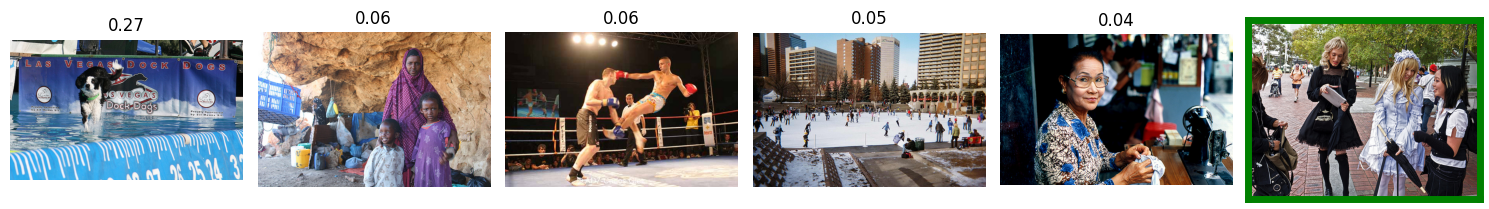

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
A man is doing a jump on a wakeboard in the water .


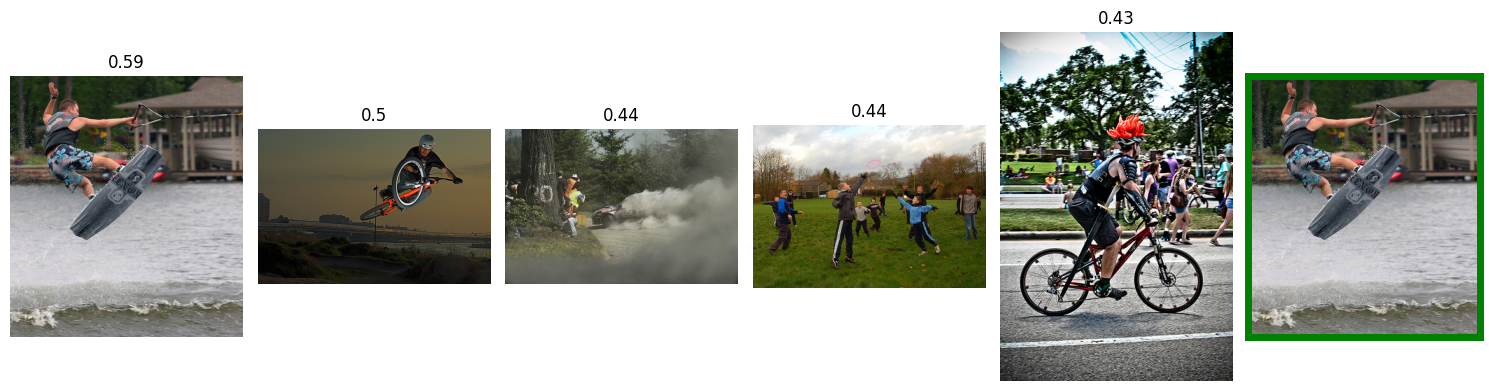

two young girls wearing pink outfits playing on yellow monkey bars .
A boy flying a red and white kite .


In [86]:
for text in list_samples:
    get_picture(text)

Наша модель показала неудовлетворительный вариант при предсказании соответствия изображения/описания на тестовой выборке. Мы видим, что только в одном варианте из четырех выиграло "верное изображение.

Но, наша функция хорошо справляется с обработкой запрещенного контента - предупреждения о таких изображениях появляются после каждого запроса с упоминанием детей.

Для поиска лучшего решения было принято использовать альтернативную модель - ViT, нейронная сеть, которая основана на архитектуре трансформера.


In [87]:
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

In [88]:
vit_model = SentenceTransformer('clip-ViT-B-32')

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [89]:
file_paths = list(glob.glob(str(Path(test_images_dir, '*.jpg'))))

In [90]:
image_embed = vit_model.encode([Image.open(i) for i in file_paths],
                                   convert_to_tensor=True,
                                   batch_size=32,
                                   show_progress_bar=True)

image_embed.shape

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([100, 512])

In [91]:
def vit_model_get_picture(query_text):
    if contains_underage_keywords(query_text, underage_keywords):
            print(query_text)
            print("Warning:  This image is unavailable in your country in compliance with local laws")
    else:
        image_embedings = vit_model.encode([query_text], 
                                           convert_to_tensor=True,
                                           show_progress_bar=False)
        
        top = util.semantic_search(image_embedings, image_embed, top_k=5)[0]
        print(query_text)
        fig = plt.figure(figsize=(15,6))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top[i]['score'], 2))
            image = Image.open(file_paths[top[i]['corpus_id']])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        if query in list(df_test['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(test_images_dir,
                                    df_test.iloc[df_test[df_test['query_text'] == query_text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            print()
        
        plt.show()
        
    return None

A race car kicks up dirt and dust on a gravel track .



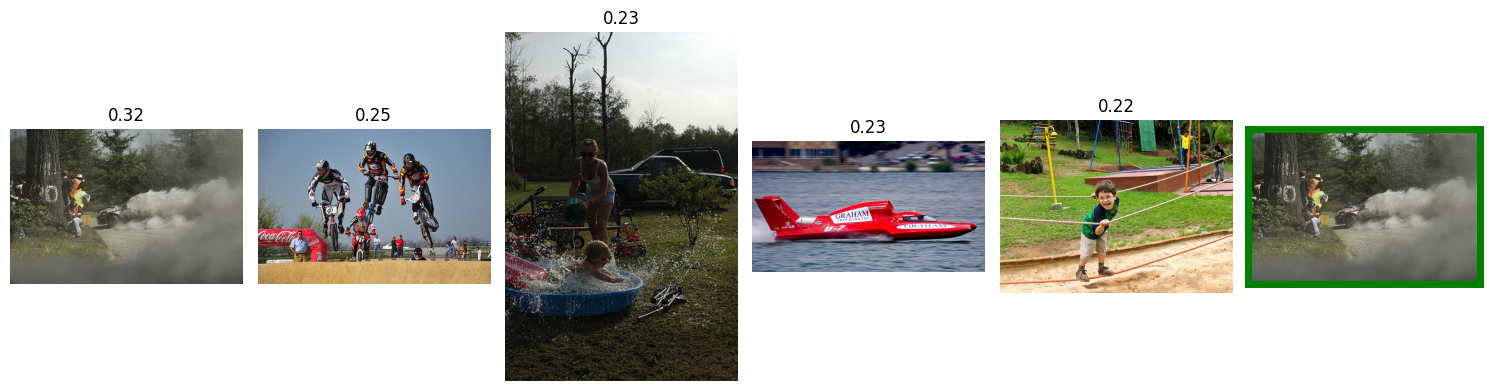

A dog is dressed in a shirt and pants on the side of the road .



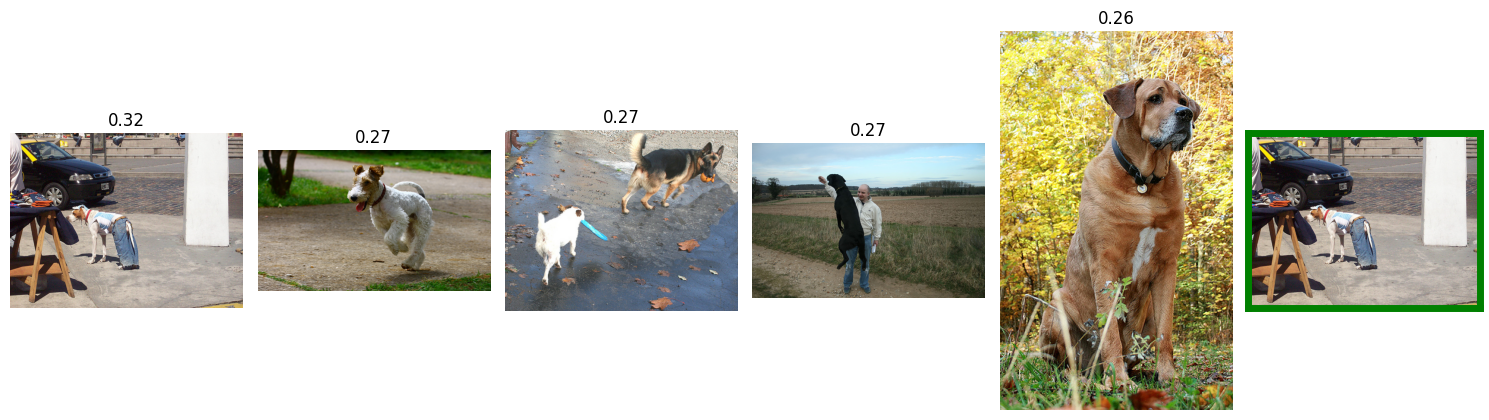

Man wearing hat and t-shirt with " Genetic Freak " sleeping on public transportation .



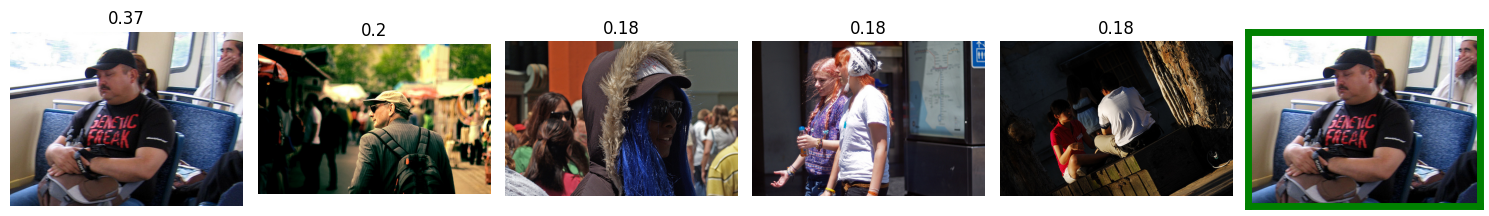

Three boys are standing in a row along an upraised wall and rail , each a level higher than the one before .
a small shaggy dog plays with a red ball on the grass .



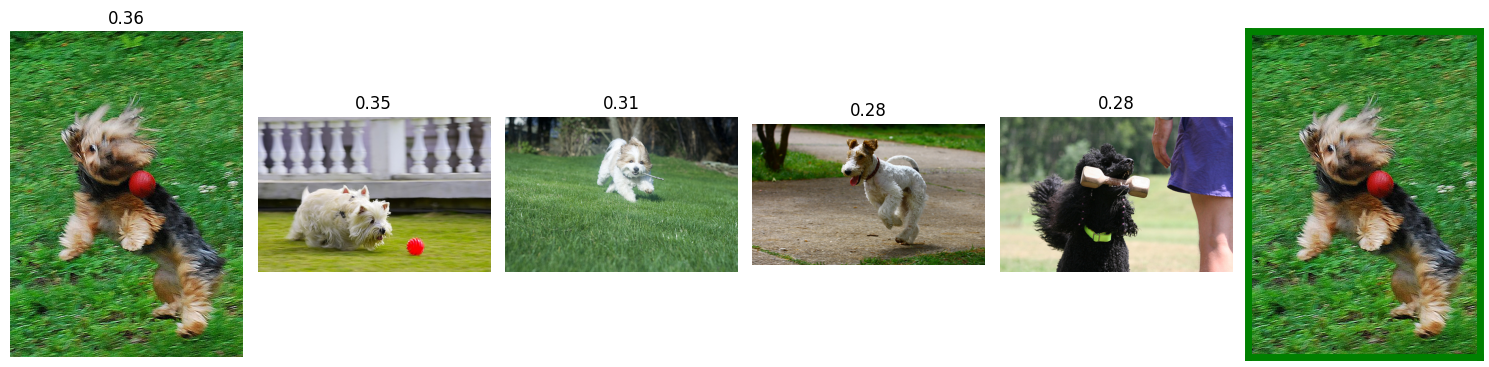

Women wearing red and black are clapping .



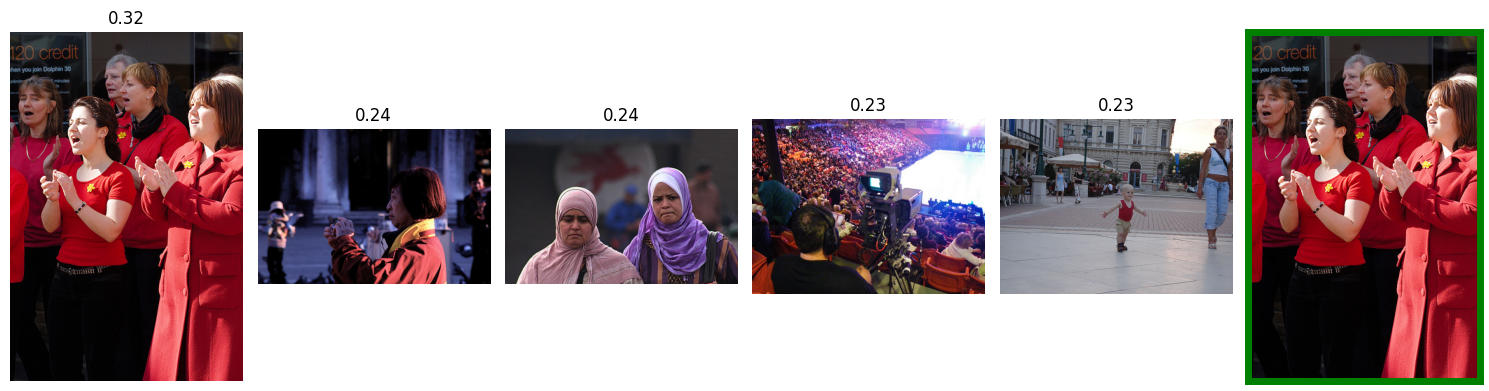

One person snowboarding while others look on .



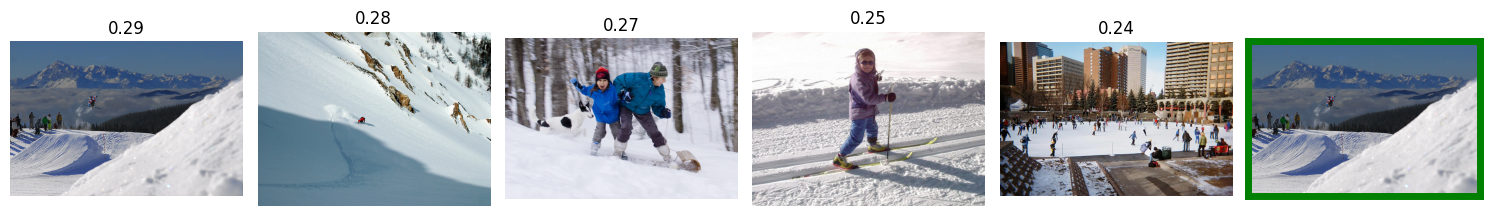

A girl on skis in snow .
A woman and a man pose with Groucho Marx disguises .



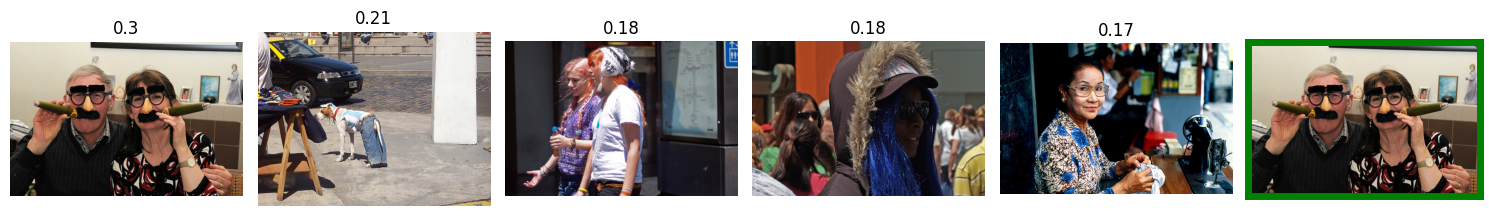

A group of friends play instruments in the middle of the woods .



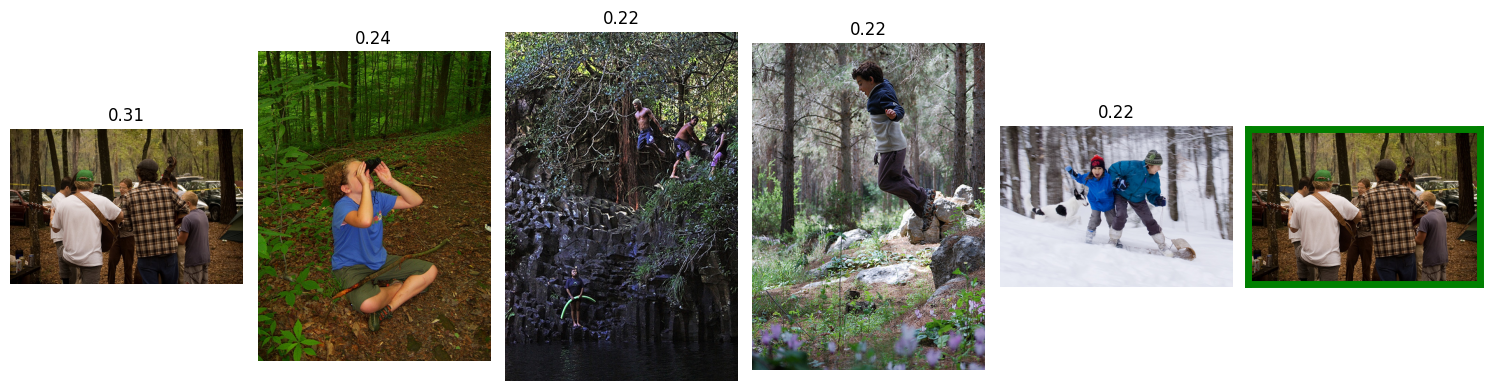

In [92]:
for query in list(df_test.sample(10)['query_text']):
    vit_model_get_picture(query_text = query)

VIT модель показала себя намного лучше - мы видим, что для 5 из 7 вариантов модель выбрала правильное изображение. Но вероятность правильного выбора в некоторых случаях близка к вероятностям других изображений. Это указывает, что модель уверена в правильном ответе, но разрыв между релевантным и нерелевантным выбором может быть небольшим. Это также может указывать на то, что модель может путаться в деталях контекста.

Модель показывает хорошие результаты, но нуждается в улучшении для повышения уверенности и обработки сложных контекстов.

## Выводы



Целью проекта было создание модели, способной находить изображения по текстовым запросам, а также предсказывать вероятность соответствия текста и изображения с целевым значением от 0 до 1. Мы провели все этапы исследования, начиная от подготовки данных до обучения моделей и анализа их результатов.

Перед началом исследования загрузили тренировочные и тестовые выборки, а также таблицы с краудсорсинговыми и экспертными оценками. Мы провели исследовательский анализ тренировочного датасета: определили наиболее часто встречающиеся слова в текстах, выявили, что большинство изображений имеют неверное описание. Далее мы создали функцию для расчета вероятности соответствия текста и изображения на основе краудсорсинговых оценок и агрегировали экспертные оценки на основе большинства. Объединили данные оценки в одну финальную, используя разные коэффициенты для краудсорсинговых и экспертных оценок, и присоединили эту оценку к тренировочной выборке. Мы также исключили изображения с детьми из тренировочной выборке в соответствии с законодательными требованиями.

Для векторизации изображений использовали сверточную сеть ResNet50, а для векторизации текстов применили TF-IDF. Объединили данные эмбеддинги в финальный датасет для обучения.

На шаге обучения моделей сначала мы обучили DummyRegressor как базовую модель, показавшую MAE 0.14. Далее мы Ridge и RandomForestRegressor, которые продемонстрировали метрику MAE 0.13 и 0.12 соответсвенно. Мы создали нейронную сеть, которая показала лучшие результаты по метрике MAE среди всех моделей - 0.08. Эта модель была выбрана для тестовой выборки.

Во время предсказания целевого признака на тестовой модели нейронная сеть корректно обработала запросы, содержащие слова, связанные с детьми, выдав дисклеймер вместо изображений. Но, модель неудовлетворительно справилась с находить поиском релеватных изображений, поэтому было принято решение использовать для предсказания предобученную модель Vit.

Модель Vit показала намного более удовлетворительные результаты, выбрав большинство изображений правильно. Но, модель не сильно уверена в своих предсказаниях, и часто выдает очень близкие вероятности нерелеватным и релевантным изображениям. Также, модель путается, когда в текстовом запросе представлен сложный контекст.

Выводы по модели:
* Модель VIT хорошо справляется с простыми текстовыми запросами, в которых описаны конкретные объекты или действия.
* Для сложных запросов с обилием деталей или контекстом модель часто присваивает высокую вероятность нерелевантным изображениям, что указывает на её недостаточную способность учитывать контекст.
* Среднее значение вероятностей у всех изображений часто распределяется равномерно, что демонстрирует низкую уверенность модели в своих предсказаниях.

Рекомендуется добавить изображения и текстовые описания с более сложными и контекстными примерами, чтобы улучшить способность модели обрабатывать разнообразные запросы.
